In [1]:
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import time
import pandas as pd
from sklearn import preprocessing

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#project_folder='/content/drive/MyDrive/Project_data/Sample_Video_Frame_Data'
project_folder = "/content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2"

In [7]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [9]:
class ASL_ModelBuilder(metaclass= abc.ABCMeta):
    
    def setup_and_configure(self,project_folder,no_of_categories_of_signs):
        self.train_path = project_folder + '/' + 'step_2_subset_data'+'/'+'train'
        self.test_path   = project_folder + '/' + 'step_2_subset_data'+'/'+'test'

        full_train_df = pd.read_csv("/content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data_train.csv")
        full_test_df = pd.read_csv("/content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data_test.csv")

        #min:47, max:195
        self.max_frame_no = 195
        '''
        video_paths = full_train_df["video_name"].values.tolist()
        self.max_frame_no = 0

        for idx, path in enumerate(video_paths):
          cap = cv2.VideoCapture(os.path.join(self.train_path, path))
          no_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

          if(self.max_frame_no < no_of_frames):
            self.max_frame_no = no_of_frames
            print("Max frame number corrected to : ",self.max_frame_no)
        '''

        #Remove some faulty videos
        full_train_df.drop(full_train_df.loc[full_train_df['video_name']== 'banana/04901.mp4'].index, inplace=True)
        full_train_df.drop(full_train_df.loc[full_train_df['video_name']== 'boy/07454.mp4'].index, inplace=True)
        full_train_df.drop(full_train_df.loc[full_train_df['video_name']== 'beard/70254.mp4'].index, inplace=True)

        label_processor = keras.layers.experimental.preprocessing.StringLookup(
          num_oov_indices=0, vocabulary=np.unique(full_train_df["tag"])
        )
        print("Categories :",label_processor.get_vocabulary())
        print("Total number of categories: ",len(label_processor.get_vocabulary()))

        #create category list
        self.categories_list = list(label_processor.get_vocabulary())

        #create a sub set
        self.train_df = full_train_df[full_train_df['tag'].isin(self.categories_list[:no_of_categories_of_signs])]
        self.test_df = full_test_df[full_test_df['tag'].isin(self.categories_list[:no_of_categories_of_signs])]

       
        le = preprocessing.LabelEncoder()
        self.train_df["tag"] = le.fit_transform(self.train_df["tag"])
        self.test_df["tag"] = le.fit_transform(self.test_df["tag"])

        self.train_df.to_csv('asl_train.csv')
        self.test_df.to_csv('asl_test.csv')

        self.train_doc = np.random.permutation(open('asl_train.csv').readlines())
        self.test_doc   = np.random.permutation(open('asl_test.csv').readlines())

        self.train_doc = self.train_doc[self.train_doc != ",Unnamed: 0,video_name,tag\n"]
        self.test_doc = self.test_doc[self.test_doc != ",Unnamed: 0,video_name,tag\n"]

        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.test_doc)


        print(f"Total videos in REDUCED training set : {self.num_train_sequences}")
        print(f"Total videos in REDUCED testing set : {self.num_val_sequences}")
        print(f"Unique categories(labels) in the REDUCED train data set :", np.unique(self.train_df['tag']))
        
    def initialize_image_properties(self,image_height=100,image_width=100,no_of_categories_of_signs=4):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=no_of_categories_of_signs
        self.total_frames=195
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        print("\nGenerator is called for ---- ",source_path)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        #print(img_idx)
        batch_size=self.batch_size
        while True:
            video_list = np.random.permutation(folder_list)
            num_batches = len(video_list)//batch_size
        
            
            for batch in range(num_batches): 
                #print("\nBATCH_NUMBER : ",batch)
                batch_data, batch_labels= self.one_batch_data(source_path,video_list,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_frames=len(video_list)%batch_size
        
            if (remaining_frames != 0):
                #print("\nEXTRA BATCH")
                batch_data, batch_labels= self.one_batch_data(source_path,video_list,num_batches,batch_size,img_idx,augment,remaining_frames)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,video_list,batch,batch_size,img_idx,augment,remaining_frames=0):
        seq_len = remaining_frames if remaining_frames else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        #print("PERMUTED VIDEO LIST :\n",video_list)
        for folder_idx in range(seq_len): 
            #print(folder_idx)
            video_path = source_path+'/'+ video_list[folder_idx + (batch*batch_size)].split(',')[2]

            cap = cv2.VideoCapture(video_path)
            no_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            width = cap.get(cv2.CAP_PROP_FRAME_WIDTH )
            height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT )
            fps =  cap.get(cv2.CAP_PROP_FPS)     
            frames = []

            repetition_count = self.max_frame_no//no_of_frames
            last_repetition_count = self.max_frame_no - (no_of_frames * repetition_count)
            
            frame_count = 0
            try:
              while True:
                  #print("FRAMEEEE_COUNTTT : ",frame_count)
                  ret, frame = cap.read()

                  '''
                  if(frame_count == 0):
                    print("VIDEO_PATH : ",video_path," -- ",no_of_frames," FRAMES"," -- (",width," , ", height, ")"," -- REPETITION : ",repetition_count," LAST REPETITION :",last_repetition_count)
                  '''

                  if not ret:
                    if(frame_count != no_of_frames):
                    #some problems in videos, few last frames missing. So treating them specially by appending
                      for y in range(no_of_frames-frame_count):
                        frames.append(frame_old)
                    #print("BREAK")
                    break
                  else:
                    frame = crop_center_square(frame)
                    

                  frame = cv2.resize(frame, (self.image_height,self.image_width))
                  frame_old = frame

                  '''
                  if(frame_count == 0):
                    cv2_imshow(frame)
                  '''
                    
                  frame = frame[:, :, [2, 1, 0]]
                  frames.append(frame)
                      
                  frame_count = frame_count + 1

                  '''
                  if len(frames) == max_frames:
                    break
                  '''
            finally:
              cap.release()

            

            #print("CORRECTED TOTAL FRAMES : ",len(frames))
            img_idx = np.round(np.linspace(0,no_of_frames-1,self.frames_to_sample)).astype(int)

            #img_idx : frame index of the video
            #print("\nIMAGE IDX : ",img_idx)
            for idx,item in enumerate(img_idx): 
                #print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0])
                #print("VIDEO_IDX: ",folder_idx," FRAME_COUNT: ",idx," FRAME_INDEX: ",item)
                image = frames[item]
                #image = np.zeros((self.image_height,self.image_width,3), np.uint8)
                #image_resized=cv2.resize(image,(self.image_height,self.image_width),interpolation = cv2.INTER_NEAREST)
            
                image_resized = image

                batch_data[folder_idx,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder_idx,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder_idx,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width),interpolation = cv2.INTER_NEAREST)
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder_idx,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder_idx,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder_idx,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder_idx, int(video_list[folder_idx + (batch*batch_size)].strip().split(',')[3])]                                                                                                                                                                                                      = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        #print("BATCH DATA SHAPE :",batch_data.shape,"BATCH LABEL SHAPE :",batch_labels.shape)
        #print("\nBATCH_LABELS : \n",batch_labels)
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        print("MODEL training is started...")
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.test_path, self.test_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        

        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [10]:
class ASL_ModelConv3D1(ASL_ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        num_filters = 16

        model = Sequential()
        model.add(Conv3D(num_filters, filtersize, padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
     
        model.add(Conv3D(num_filters*2, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        
        model.add(Conv3D(num_filters*4, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        '''
        model.add(Conv3D(num_filters*8, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        '''

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
no_of_categories_of_signs = 4

Transfer Learning with GRU and training all weights


In [12]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ASL_ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


MODEL 1

In [13]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.setup_and_configure(project_folder,no_of_categories_of_signs)
rnn_cnn_tl2.initialize_image_properties(image_height=160,image_width=160,no_of_categories_of_signs=no_of_categories_of_signs)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=30,batch_size=8,num_epochs=35)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Categories : ['about', 'balance', 'banana', 'beard', 'boy', 'business', 'christmas', 'clock', 'close', 'convince', 'country', 'cute', 'daughter', 'day', 'delicious', 'enjoy', 'first', 'friend', 'girl', 'good', 'hair', 'here', 'home', 'husband', 'inform', 'interest', 'join', 'list', 'lose', 'name', 'new', 'now', 'office', 'old', 'president', 'pull', 'remember', 'ride', 'right', 'russia', 'salt', 'sandwich', 'show', 'small', 'soon', 'student', 'sunday', 'tea', 'tomato', 'why', 'wife', 'win', 'window', 'you']
Total number of categories:  54
Total videos in REDUCED training set : 42
Total videos in REDUCED testing set : 12
Unique categories(labels) in the REDUCED train data set : [0 1 2 3]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (T

In [14]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
# store starting time
begin_time = time.time()

history_rnn_cnn_tl2_1_model = rnn_cnn_tl2.train_model(rnn_cnn_tl2_model)

# store ending time
end_time = time.time()

print(f"Total runtime for training model is {end_time - begin_time}")

Total Params: 4872772
MODEL training is started...

Generator is called for ----  /content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data/train
Epoch 1/35
6/6 [==============================] - ETA: 0s - loss: 1.9140 - categorical_accuracy: 0.2381
Generator is called for ----  /content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data/test
6/6 [==============================] - 36s 6s/step - loss: 1.9140 - categorical_accuracy: 0.2381 - val_loss: 1.4945 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2021-09-1814_47_26.669286/model-00001-1.91400-0.23810-1.49450-0.25000.h5
Epoch 2/35
6/6 [==============================] - 19s 3s/step - loss: 1.3761 - categorical_accuracy: 0.3810 - val_loss: 1.4427 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-09-1814_47_26.669286/model-00002-1.37610-0.38095-1.44266-0.25000.h5
Epoch 3/35
6/6 [==============================] - 19s 3s/step - loss: 1.23

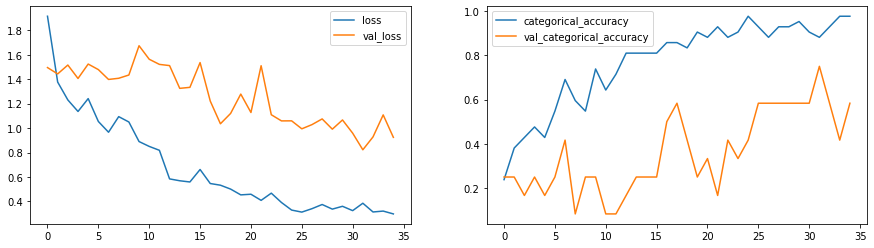

In [15]:
plot(history_rnn_cnn_tl2_1_model)

MODEL 2

In [16]:
rnn_cnn_tl2_4=RNNCNN_TL2()
rnn_cnn_tl2_4.setup_and_configure(project_folder,no_of_categories_of_signs)
rnn_cnn_tl2_4.initialize_image_properties(image_height=160,image_width=160,no_of_categories_of_signs=no_of_categories_of_signs)
rnn_cnn_tl2_4.initialize_hyperparams(frames_to_sample=60,batch_size=8,num_epochs=35)
rnn_cnn_tl2_4_model=rnn_cnn_tl2_4.define_model(gru_cells=256,dense_neurons=256,dropout=0.25)
rnn_cnn_tl2_4_model.summary()

Categories : ['about', 'balance', 'banana', 'beard', 'boy', 'business', 'christmas', 'clock', 'close', 'convince', 'country', 'cute', 'daughter', 'day', 'delicious', 'enjoy', 'first', 'friend', 'girl', 'good', 'hair', 'here', 'home', 'husband', 'inform', 'interest', 'join', 'list', 'lose', 'name', 'new', 'now', 'office', 'old', 'president', 'pull', 'remember', 'ride', 'right', 'russia', 'salt', 'sandwich', 'show', 'small', 'soon', 'student', 'sunday', 'tea', 'tomato', 'why', 'wife', 'win', 'window', 'you']
Total number of categories:  54
Total videos in REDUCED training set : 42
Total videos in REDUCED testing set : 12
Unique categories(labels) in the REDUCED train data set : [0 1 2 3]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 60, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_5 

In [17]:
print("Total Params:", rnn_cnn_tl2_4_model.count_params())
# store starting time
begin_time = time.time()

history_rnn_cnn_tl2_4_model = rnn_cnn_tl2_4.train_model(rnn_cnn_tl2_4_model)

# store ending time
end_time = time.time()

print(f"Total runtime for training model is {end_time - begin_time}")

Total Params: 6643652
MODEL training is started...

Generator is called for ----  /content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data/train
Epoch 1/35
6/6 [==============================] - ETA: 0s - loss: 1.9272 - categorical_accuracy: 0.1667
Generator is called for ----  /content/drive/MyDrive/ProjectRelated/CNN_GRU_Sample/STEP_2/step_2_subset_data/test
6/6 [==============================] - 39s 6s/step - loss: 1.9272 - categorical_accuracy: 0.1667 - val_loss: 1.3955 - val_categorical_accuracy: 0.4167

Epoch 00001: saving model to model_init_2021-09-1814_58_43.697266/model-00001-1.92724-0.16667-1.39546-0.41667.h5
Epoch 2/35
6/6 [==============================] - 31s 5s/step - loss: 1.3982 - categorical_accuracy: 0.4048 - val_loss: 1.5042 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-09-1814_58_43.697266/model-00002-1.39823-0.40476-1.50417-0.25000.h5
Epoch 3/35
6/6 [==============================] - 32s 5s/step - loss: 0.96

KeyboardInterrupt: ignored

In [ ]:
plot(history_rnn_cnn_tl2_4_model)

MODEL 3

In [ ]:
asl_conv_3d1=ASL_ModelConv3D1()
asl_conv_3d1.setup_and_configure(project_folder,no_of_categories_of_signs)
asl_conv_3d1.initialize_image_properties(image_height=160,image_width=160,no_of_categories_of_signs=no_of_categories_of_signs)
asl_conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=8,num_epochs=10)
asl_conv_3d1_model=asl_conv_3d1.define_model(dense_neurons=32,dropout=0.25)

print("Total Params:", asl_conv_3d1_model.count_params())

asl_conv_3d1_model.summary()

In [ ]:
# store starting time
begin_time = time.time()
history_asl_model1 = asl_conv_3d1.train_model(asl_conv_3d1_model)
 
# store ending time
end_time = time.time()

print(f"Total runtime for training model is {end_time - begin_time}")

In [ ]:
plot(history_asl_model1)